In [23]:
import torch.nn.functional as F
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import pandas as pd

In [24]:
with open('chat.txt', "r+") as file:
    chat = file.readlines()

In [25]:
chat = "\n".join(chat)

In [26]:
chars = sorted(list(set(chat))) + ['<s>']
vocab_size = len(chars)
tokeniser = {c:i  for i, c in enumerate(chars)}
detokeniser = {i:c  for i, c in enumerate(chars)}

In [8]:
sentence_enc = [tokeniser[c] for c in chat[:100]]
sentence_dec = [detokeniser[t] for t in sentence_enc]
sentence_enc, "".join(sentence_dec)

([61,
  19,
  23,
  17,
  18,
  26,
  17,
  20,
  18,
  20,
  23,
  14,
  2,
  19,
  18,
  28,
  22,
  23,
  28,
  22,
  21,
  63,
  2,
  45,
  74,
  79,
  72,
  84,
  2,
  37,
  83,
  80,
  84,
  84,
  2,
  42,
  66,
  68,
  76,
  2,
  46,
  66,
  67,
  28,
  2,
  133,
  47,
  70,
  84,
  84,
  66,
  72,
  70,
  84,
  2,
  66,
  79,
  69,
  2,
  68,
  66,
  77,
  77,
  84,
  2,
  66,
  83,
  70,
  2,
  70,
  79,
  69,
  15,
  85,
  80,
  15,
  70,
  79,
  69,
  2,
  70,
  79,
  68,
  83,
  90,
  81,
  85,
  70,
  69,
  16,
  2,
  49,
  79,
  77,
  90,
  2,
  81,
  70,
  80,
  81],
 '[15/08/2025, 10:45:43] Kings Cross Hack Lab: \u200eMessages and calls are end-to-end encrypted. Only peop')

In [26]:

# generating the dataset
CONTEXT_LENGTH = 4
X = []
Y = []

context = ['<s>'] * CONTEXT_LENGTH
for i, c in enumerate(chat):
    context = context[1:] + [c]
    X.append([tokeniser[c] for c in context]) 
    if i == len(chat) - 1:
        Y.append([tokeniser[c] for c in context[1:] + [' ']])
    else:
        Y.append([tokeniser[c] for c in context[1:] + [chat[i+1]]])

X = torch.tensor(X)
Y = torch.tensor(Y)

tst_idx = int(X.shape[0])
val_idx = int(tst_idx * 0.9)
tr_idx =  int(tst_idx * 0.8)

X_tr = X[0:tr_idx]
Y_tr = Y[0:tr_idx]

X_val = X[tr_idx:tst_idx]
Y_val = Y[tr_idx:tst_idx]

X_tst = X[val_idx:]
Y_tst = Y[val_idx:]

In [28]:
emb = torch.randn(vocab_size, 2)
emb.shape

torch.Size([343, 2])

In [29]:
small_X = X[:200]

print(small_X.shape)

emb_X = emb[small_X]

torch.Size([200, 4])


In [117]:
attn = torch.zeros_like(emb_X).float()

for i, x in enumerate(emb_X):
    for j, c in enumerate(x):
        attn[i,j] = (x[:j+1].float()).mean(0)

In [118]:
emb_X[5]

tensor([[ 1.0012, -1.3091],
        [ 0.4356, -0.3819],
        [-1.4243, -0.0738],
        [ 0.5725,  2.0946]])

In [119]:
attn[5]

tensor([[ 1.0012, -1.3091],
        [ 0.7184, -0.8455],
        [ 0.0042, -0.5883],
        [ 0.1463,  0.0825]])

In [124]:
attn_v = (emb_X.transpose(1,2) @ torch.triu(1/torch.arange(1,5,1).expand(4,4), diagonal=0)).transpose(-2,-1)
attn_v[5]

tensor([[ 1.0012, -1.3091],
        [ 0.7184, -0.8455],
        [ 0.0042, -0.5883],
        [ 0.1463,  0.0825]])

In [138]:
torch.triu(1/torch.arange(1,5,1).expand(4,4), diagonal=0)

tensor([[1.0000, 0.5000, 0.3333, 0.2500],
        [0.0000, 0.5000, 0.3333, 0.2500],
        [0.0000, 0.0000, 0.3333, 0.2500],
        [0.0000, 0.0000, 0.0000, 0.2500]])

In [ ]:
emb_X[5] # (T, C) -> (4, 2)

tensor([[ 1.0012, -1.3091],
        [ 0.4356, -0.3819],
        [-1.4243, -0.0738],
        [ 0.5725,  2.0946]])

In [175]:
emb_X.exp() / emb_X.exp().sum(0)

tensor([[[0.0039, 0.0022],
         [0.0039, 0.0022],
         [0.0039, 0.0022],
         [0.0101, 0.0017]],

        [[0.0039, 0.0022],
         [0.0039, 0.0022],
         [0.0100, 0.0017],
         [0.0008, 0.0123]],

        [[0.0039, 0.0022],
         [0.0101, 0.0018],
         [0.0008, 0.0124],
         [0.0077, 0.0008]],

        ...,

        [[0.0066, 0.0012],
         [0.0018, 0.0021],
         [0.0028, 0.0020],
         [0.0043, 0.0077]],

        [[0.0018, 0.0021],
         [0.0028, 0.0021],
         [0.0043, 0.0078],
         [0.0062, 0.0341]],

        [[0.0028, 0.0021],
         [0.0043, 0.0081],
         [0.0062, 0.0344],
         [0.0017, 0.0099]]])

In [174]:
torch.tril(1/torch.arange(4,0,-1).expand(4,4), diagonal=0)

tensor([[0.2500, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.3333, 0.0000, 0.0000],
        [0.2500, 0.3333, 0.5000, 0.0000],
        [0.2500, 0.3333, 0.5000, 1.0000]])

In [163]:
emb_X[5].T @ (emb_X[5] / emb_X[5].sum(0)).float()

tensor([[ 6.0645, -0.5241],
        [-0.2955, 18.9556]])

In [139]:
attn_v_t = torch.tril(1/torch.arange(4,0,-1).expand(4,4), diagonal=0) @ emb_X
attn_v_t[5]

tensor([[ 0.2503, -0.3273],
        [ 0.3955, -0.4546],
        [-0.3166, -0.4915],
        [ 0.2559,  1.6032]])

In [68]:
X.shape, torch.triu(1/torch.arange(1,9,1).expand(8,8), diagonal=0).shape

(torch.Size([618527, 8]), torch.Size([8, 8]))

In [81]:
(torch.randn(123, 8, 5).transpose(1,2) @ torch.triu(1/torch.arange(1,9,1).expand(8,8), diagonal=0)).shape

torch.Size([123, 5, 8])

In [76]:
torch.randn(4,2,3).transpose(-1,-2).shape

torch.Size([4, 3, 2])

In [94]:
attn_v = X.float() @ torch.triu(1/torch.arange(1,9,1).expand(8,8), diagonal=0)

In [97]:
(attn == attn_v)

tensor([[ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True, False,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True]])

In [104]:
sm = torch.triu(torch.ones(8,8), diagonal=0)
sm = torch.masked_fill(sm, sm == 0, float('-inf'))
sm

tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [-inf, 1., 1., 1., 1., 1., 1., 1.],
        [-inf, -inf, 1., 1., 1., 1., 1., 1.],
        [-inf, -inf, -inf, 1., 1., 1., 1., 1.],
        [-inf, -inf, -inf, -inf, 1., 1., 1., 1.],
        [-inf, -inf, -inf, -inf, -inf, 1., 1., 1.],
        [-inf, -inf, -inf, -inf, -inf, -inf, 1., 1.],
        [-inf, -inf, -inf, -inf, -inf, -inf, -inf, 1.]])

In [122]:
sm_exp = torch.exp(sm)
sm_ans = sm_exp / sm_exp.sum(dim=0)
sm_ans

tensor([[1.0000, 0.5000, 0.3333, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.5000, 0.3333, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.3333, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1250]])

In [123]:
sm_exp

tensor([[2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183],
        [0.0000, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183],
        [0.0000, 0.0000, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183],
        [0.0000, 0.0000, 0.0000, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.7183, 2.7183, 2.7183, 2.7183],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.7183, 2.7183, 2.7183],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.7183, 2.7183],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.7183]])

In [124]:
sm_exp = torch.triu(torch.ones(8,8), diagonal=0)
sm_ans = sm_exp / sm_exp.sum(dim=0)
sm_ans

tensor([[1.0000, 0.5000, 0.3333, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.5000, 0.3333, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.3333, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1250]])

In [110]:
F.softmax(sm, dim=1)

tensor([[0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250],
        [0.0000, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429],
        [0.0000, 0.0000, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.0000, 0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.2500, 0.2500, 0.2500],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.3333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]])

In [27]:

# generating the dataset
CONTEXT_LENGTH = 128
X = []
Y = []

context = ['<s>'] * CONTEXT_LENGTH
for i, c in enumerate(chat):
    context = context[1:] + [c]
    X.append([tokeniser[c] for c in context]) 
    if i == len(chat) - 1:
        Y.append([tokeniser[c] for c in context[1:] + [' ']])
    else:
        Y.append([tokeniser[c] for c in context[1:] + [chat[i+1]]])

X = torch.tensor(X)
Y = torch.tensor(Y)

tst_idx = int(X.shape[0])
val_idx = int(tst_idx * 0.9)
tr_idx =  int(tst_idx * 0.8)

X_tr = X[0:tr_idx]
Y_tr = Y[0:tr_idx]

X_val = X[tr_idx:tst_idx]
Y_val = Y[tr_idx:tst_idx]

X_tst = X[val_idx:]
Y_tst = Y[val_idx:]

In [7]:
Y_tr.shape, X_tr.shape

(torch.Size([494821, 128]), torch.Size([494821, 128]))

In [70]:
TOK_EMB_DIM = 512
POS_EMB_DIM = 512

# HEAD_SIZE = 16
NUM_HEADS = 8

DROPOUT_RATE = 0.2

COMPRESSION_RATIO = 2
HIDDEN_DIM = TOK_EMB_DIM // COMPRESSION_RATIO
Z_DIM = HIDDEN_DIM // COMPRESSION_RATIO

MINI_NUM_HEADS = 2


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = "cpu"

class BasicTransformer(nn.Module):
    def __init__(self):
        super().__init__()

        self.tok_emb = nn.Embedding(vocab_size, TOK_EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, POS_EMB_DIM)
        self.flatten = nn.Flatten()

        self.query = nn.Linear(TOK_EMB_DIM, HEAD_SIZE) # (C, H)
        self.key = nn.Linear(TOK_EMB_DIM, HEAD_SIZE) # (C, H)
        self.value = nn.Linear(TOK_EMB_DIM, HEAD_SIZE) # (C, H)
        self.linear1 = nn.Linear(CONTEXT_LENGTH * HEAD_SIZE, vocab_size)


    def forward(self, x, y = None):
        # (B, T)
        tok_emb = self.tok_emb(x) # (B, T, C)
        pos_emb = self.pos_emb(torch.arange(0,CONTEXT_LENGTH)) # (B, T, C)
        x = tok_emb + pos_emb # (B, T, C)

        query = self.query(x) # B, (T, C) @ (C, H) -> B, (T, H)
        key = self.key(x) # B, (T, C) @ (C, H) -> B, (T, H)
        value: torch.Tensor = self.value(x) # B, (T, C) @ (C, H) -> B, (T, H)

        contrib = query @ key.transpose(1,2) # B, (T, H) @ (H, T) -> (T, T)
        contrib = torch.triu(contrib, diagonal=0) # (T, T)
        contrib = torch.masked_fill(contrib, contrib == 0, float('-inf')) # (T, T)
        contrib = torch.softmax(contrib * (HEAD_SIZE ** -0.5), dim=-1) # (T, T)
        x = (value.transpose(-2, -1) @ contrib).transpose(-2,-1) # B, (H, T) @ (T, T) -> H, T -> B, T, H

        x = self.flatten(x)
        logits = self.linear1(x)

        loss = None

        if y is not None:
            loss = F.cross_entropy(logits, y)

        return logits, loss
    
    def generate(self, x):
        logits, _ = self.forward(x)
        probs = F.softmax(logits, dim=1)
        pred = torch.multinomial(probs, 1)

        return pred
    
class TransformerWithAttn(nn.Module):
    def __init__(self):
        super().__init__()

        self.tok_emb = nn.Embedding(vocab_size, TOK_EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, POS_EMB_DIM)
        self.flatten = nn.Flatten()

        self.attn1 = Attention(TOK_EMB_DIM, HEAD_SIZE)
        self.linear1 = nn.Linear(CONTEXT_LENGTH * HEAD_SIZE, vocab_size)


    def forward(self, x, y = None):
        # (B, T)
        tok_emb = self.tok_emb(x) # (B, T, C)
        pos_emb = self.pos_emb(torch.arange(0,CONTEXT_LENGTH)) # (B, T, C)
        x = tok_emb + pos_emb # (B, T, C)

        x = self.attn1(x)
        x = self.flatten(x)
        logits = self.linear1(x)

        loss = None

        if y is not None:
            loss = F.cross_entropy(logits, y)

        return logits, loss
    
    def generate(self, x):
        logits, _ = self.forward(x)
        probs = F.softmax(logits, dim=1)
        pred = torch.multinomial(probs, 1)

        return pred


class TransformerWithMultiHeadAttn(nn.Module):
    def __init__(self):
        super().__init__()

        self.tok_emb = nn.Embedding(vocab_size, TOK_EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, POS_EMB_DIM)
        self.flatten = nn.Flatten()

        self.attn1 = MultiHeadAttention(num_heads=TOK_EMB_DIM // HEAD_SIZE, embedding_dim=TOK_EMB_DIM, head_size=HEAD_SIZE)
        self.linear1 = nn.Linear(CONTEXT_LENGTH * TOK_EMB_DIM, vocab_size)


    def forward(self, x, y = None):
        # (B, T)
        tok_emb = self.tok_emb(x) # (B, T, C)
        pos_emb = self.pos_emb(torch.arange(0,CONTEXT_LENGTH)) # (B, T, C)
        x = tok_emb + pos_emb # (B, T, C)

        x = self.attn1(x) # (B, T, H), 
        # num_heads = TOK_EMB_DIM // HEAD_SIZE
        # H * num_heads = tok_emb
        # therefore, x (B, T, tok_emb)

        x = self.flatten(x)
        logits = self.linear1(x)

        loss = None

        if y is not None:
            loss = F.cross_entropy(logits, y)

        return logits, loss
    
    def generate(self, x):
        logits, _ = self.forward(x)
        probs = F.softmax(logits, dim=1)
        pred = torch.multinomial(probs, 1)

        return pred
    
class VAETransformerBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.attn = MultiHeadAttention(num_heads=NUM_HEADS, embedding_dim=TOK_EMB_DIM, head_size=TOK_EMB_DIM // NUM_HEADS)
        
        self.vae = VariationalAutoAttentionEncoder(input_dim=TOK_EMB_DIM, hidden_dim=HIDDEN_DIM, z_dim=Z_DIM)
        self.attn_z = MultiHeadAttention(num_heads=MINI_NUM_HEADS, embedding_dim=Z_DIM, head_size=Z_DIM // MINI_NUM_HEADS)

        self.mlp = MLPLayer(TOK_EMB_DIM, TOK_EMB_DIM)
        self.layer_norm = nn.LayerNorm(TOK_EMB_DIM)

        self.vae_training = True

    def set_vae_training(self, is_vae_training: bool):
        self.vae.vae_training = is_vae_training

    def forward(self, input):
        # (B, T)
        x, acc_loss = input
        x_for_vae = x.detach()

        x_hoc, vae_loss = self.vae(x_for_vae)
        x_attn = self.attn(x)

        x = x_attn + x_hoc + x

        x = self.mlp(x)
        x = self.layer_norm(x)

        return x, acc_loss + vae_loss
    

class VAETransformer(nn.Module):
    def __init__(self, num_blocks):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, TOK_EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, POS_EMB_DIM)

        self.blocks = nn.Sequential(*[VAETransformerBlock() for _ in range(num_blocks)])        
     
        self.layer_norm = nn.LayerNorm(TOK_EMB_DIM)
        self.linear = nn.Linear(TOK_EMB_DIM, vocab_size)
        
        self.vae_training = True

    def set_vae_training(self, is_vae_training: bool):
        for vae in self.blocks.children():
            vae.set_vae_training(is_vae_training)

    def forward(self, x, y = None):
        # (B, T)
        tok_emb = self.tok_emb(x) # (B, T, C)
        pos_emb = self.pos_emb(torch.arange(0,x.shape[1]).to(device)) # (B, T, C)
        x = tok_emb + pos_emb # (B, T, C)

        x, vae_loss = self.blocks((x, torch.tensor(0.0, device=device)))
        
        x = self.layer_norm(x)
        logits = self.linear(x)

        loss = None

        if y is not None:
            loss = F.cross_entropy(logits.view(logits.shape[0] * logits.shape[1], vocab_size), y.view(y.shape[0] * y.shape[1])) + (0.1 * vae_loss)

        return logits, loss
    
    def generate(self, x):
        logits, _ = self.forward(x)
        logits = logits[:,-1,:]
        probs = F.softmax(logits, dim=-1)
        pred = torch.multinomial(probs, 1)

        return pred


class VAETransformerSingle(nn.Module):
    def __init__(self):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, TOK_EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, POS_EMB_DIM)
        self.attn = MultiHeadAttention(num_heads=NUM_HEADS, embedding_dim=TOK_EMB_DIM, head_size=TOK_EMB_DIM // NUM_HEADS)
        
        self.vae = VariationalAutoAttentionEncoder(input_dim=TOK_EMB_DIM, hidden_dim=HIDDEN_DIM, z_dim=Z_DIM)
        self.attn_z = MultiHeadAttention(num_heads=MINI_NUM_HEADS, embedding_dim=Z_DIM, head_size=Z_DIM // MINI_NUM_HEADS)

        self.mlp = MLPLayer(TOK_EMB_DIM, TOK_EMB_DIM)
        self.layer_norm = nn.LayerNorm(TOK_EMB_DIM)
        self.linear = nn.Linear(TOK_EMB_DIM, vocab_size)
        
        self.vae_training = True

    def forward(self, x, y = None):
        # (B, T)
        if self.vae_training:
            self.vae.vae_training = True

        tok_emb = self.tok_emb(x) # (B, T, C)
        pos_emb = self.pos_emb(torch.arange(0,x.shape[1]).to(device)) # (B, T, C)
        x = tok_emb + pos_emb # (B, T, C)


        x_hoc, vae_loss = self.vae(x)
        x = self.attn(x) + x + x_hoc

        x = self.mlp(x)
        x = self.layer_norm(x)
        logits = self.linear(x)

        loss = None

        if y is not None:
            loss = F.cross_entropy(logits.view(logits.shape[0] * logits.shape[1], vocab_size), y.view(y.shape[0] * y.shape[1])) + (0.1 * vae_loss)

        return logits, loss
    
    def generate(self, x):
        logits, _ = self.forward(x)
        logits = logits[:,-1,:]
        probs = F.softmax(logits, dim=-1)
        pred = torch.multinomial(probs, 1)

        return pred
    


class ControlVAETransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, TOK_EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, POS_EMB_DIM)
        self.attn = MultiHeadAttention(num_heads=NUM_HEADS, embedding_dim=TOK_EMB_DIM, head_size=TOK_EMB_DIM // NUM_HEADS)
        
        self.mlp = MLPLayer(TOK_EMB_DIM, TOK_EMB_DIM)
        self.layer_norm = nn.LayerNorm(TOK_EMB_DIM)
        self.linear = nn.Linear(TOK_EMB_DIM, vocab_size)
        
    def forward(self, x, y = None):
        # (B, T)
        tok_emb = self.tok_emb(x) # (B, T, C)
        pos_emb = self.pos_emb(torch.arange(0,CONTEXT_LENGTH).to(device)) # (B, T, C)
        x = tok_emb + pos_emb # (B, T, C)
        x_res = x
        x = self.attn(x)

        if self.vae_training:
            x = x + x_res
        else:
            x = x + x_hoc + x_res

        x = self.mlp(x)
        x = self.layer_norm(x)
        logits = self.linear(x)

        loss = None

        if y is not None:
            loss = F.cross_entropy(logits.view(logits.shape[0] * logits.shape[1], vocab_size), y.view(y.shape[0] * y.shape[1])) + vae_loss

        return logits, loss
    
    def generate(self, x):
        logits, _ = self.forward(x)
        logits = logits[:,-1,:]
        probs = F.softmax(logits, dim=-1)
        pred = torch.multinomial(probs, 1)

        return pred



class Transformer(nn.Module):
    def __init__(self, num_blocks):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, TOK_EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, POS_EMB_DIM)
        self.blocks = nn.Sequential(*[TransformerBlock(TOK_EMB_DIM, NUM_HEADS) for _ in range(num_blocks)])
        self.layer_norm = nn.LayerNorm(TOK_EMB_DIM)
        self.linear = nn.Linear(TOK_EMB_DIM, vocab_size)
        self.flatten = nn.Flatten()

    def forward(self, x, y = None):
        # (B, T)
        tok_emb = self.tok_emb(x) # (B, T, C)
        pos_emb = self.pos_emb(torch.arange(0,CONTEXT_LENGTH).to(device)) # (B, T, C)
        x = tok_emb + pos_emb # (B, T, C)

        x = self.blocks(x)

        x = self.layer_norm(x)
        logits = self.linear(x) # (B, T, vocab_size)

        loss = None

        if y is not None:
            loss = F.cross_entropy(logits.view(logits.shape[0] * logits.shape[1], vocab_size), y.view(y.shape[0] * y.shape[1]))

        return logits, loss
    
    def generate(self, x):
        logits, _ = self.forward(x)
        logits = logits[:,-1,:]
        probs = F.softmax(logits, dim=-1)
        pred = torch.multinomial(probs, 1)

        return pred

class TransformerBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super().__init__()

        self.attn1 = MultiHeadAttention(num_heads=num_heads, embedding_dim=embedding_dim, head_size=embedding_dim // num_heads)
        # self.attn2 = MultiHeadAttention(num_heads=embedding_dim // head_size, embedding_dim=embedding_dim, head_size=head_size)
        self.mlp = MLP(embedding_dim=embedding_dim, expansion_factor=4)
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)


    def forward(self, x):
        out = self.layer_norm1(x)
        x = x + self.attn1(out) # (B, T, C)
        # x = self.attn2(x) # (B, T, C)
        out = self.layer_norm2(x)
        x = x + self.mlp(out) # (B, T, C)

        return x
    
class MLPLayer(nn.Module):
    def __init__(self, input_dim, output_dim, use_relu=True):
        super().__init__()

        self.linear = nn.Linear(input_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(DROPOUT_RATE)
        self.lnorm = nn.LayerNorm(output_dim)

        self.use_relu = use_relu

    def forward(self, x):
        # (B, T, I)
        x = self.linear(x) # (B, T, O)
        x = self.lnorm(x)

        if self.use_relu:
            x = self.relu(x)

        x = self.dropout(x)

        return x


class MLP(nn.Module):
    def __init__(self, embedding_dim, expansion_factor):
        super().__init__()

        self.linear1 = nn.Linear(embedding_dim, expansion_factor * embedding_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(embedding_dim * expansion_factor, embedding_dim)
        self.dropout = nn.Dropout(DROPOUT_RATE)

    def forward(self, x):
        # (B, T, tok_emb)
        x = self.linear1(x) # (B, T, 4 * tok_emb)
        x = self.relu(x) # (B, T, 4 * tok_emb)
        x = self.linear2(x) # (B, T, tok_emb)
        x = self.dropout(x)

        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, embedding_dim, head_size):
        super().__init__()

        self.attns = nn.ModuleList(Attention(embedding_dim, head_size) for _ in range(num_heads))
        self.projection = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(DROPOUT_RATE)

    def forward(self, x):
        x = torch.concat([attn(x) for attn in self.attns], dim=-1) 
        # B, T, (H x num_heads) -> (4 x 8) -> 32 == C (tok_emd)
        x = self.projection(x)
        x = self.dropout(x)

        return x
    

class Attention(nn.Module):
    def __init__(self, embedding_dim, head_size):
        super().__init__()
        self.query = nn.Linear(embedding_dim, head_size) # (C, H)
        self.key = nn.Linear(embedding_dim, head_size) # (C, H)
        self.value = nn.Linear(embedding_dim, head_size) # (C, H)
        self.dropout = nn.Dropout(DROPOUT_RATE)

        self.head_size = head_size

    def forward(self, x):
        query = self.query(x) # B, (T, C) @ (C, H) -> B, (T, H)
        key = self.key(x) # B, (T, C) @ (C, H) -> B, (T, H)
        value: torch.Tensor = self.value(x) # B, (T, C) @ (C, H) -> B, (T, H)
        B, T, C = x.shape

        contrib = query @ key.transpose(-2,-1) # B, (T, H) @ (H, T) -> (T, T)
        contrib = contrib * (self.head_size ** -0.5)
        tril = torch.tril(torch.ones(T, T, device=x.device)) 
        contrib = contrib.masked_fill(tril == 0, float('-inf')) # (T, T)
        contrib = F.softmax(contrib, dim=-1) # (T, T)


        # contrib = query @ key.transpose(-2,-1) # B, (T, H) @ (H, T) -> (T, T)
        # contrib = torch.triu(contrib, diagonal=0).to(device) # (T, T)
        # contrib = torch.masked_fill(contrib, contrib == 0, float('-inf')) # (T, T)
        # contrib = torch.softmax(contrib * (self.head_size ** -0.5), dim=-1) # (T, T)
        # x = (value.transpose(-2, -1) @ contrib).transpose(-2,-1) # B, (H, T) @ (T, T) -> H, T -> B, T, H
        
        x = contrib @ value #(T, T) @  B, (T, H) -> H, T -> B, T, H
        x = self.dropout(x)

        return x
    
class AttentionEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super().__init__()
        self.attn = Attention(input_dim, hidden_dim)
        self.lnorm = nn.LayerNorm(hidden_dim)
        self.mlp_mu = MLPLayer(hidden_dim, z_dim, use_relu=False)
        self.mlp_sigma = MLPLayer(hidden_dim, z_dim, use_relu=False)

    def forward(self, x):
        attn_output = self.attn(x)
        x = self.lnorm(attn_output)
        mu = self.mlp_mu(x)
        sigma = self.mlp_sigma(x)

        return mu, sigma


class CrossAttention(nn.Module):
    def __init__(self, embedding_dim, head_size):
        super().__init__()
        self.query = nn.Linear(embedding_dim, head_size) # (C, H)
        self.key = nn.Linear(embedding_dim, head_size) # (C, H)
        self.value = nn.Linear(embedding_dim, head_size) # (C, H)

        self.head_size = head_size

    def forward(self, x_db, x_client):
        query = self.query(x_client) # B, (T, C) @ (C, H) -> B, (T, H)
        key = self.key(x_db) # B, (T, C) @ (C, H) -> B, (T, H)
        value = self.value(x_db) # B, (T, C) @ (C, H) -> B, (T, H)

        B, T, C = x.shape

        contrib = query @ key.transpose(-2,-1) # B, (T, H) @ (H, T) -> (T, T)
        contrib = contrib * (self.head_size ** -0.5)
        tril = torch.tril(torch.ones(T, T, device=x.device))
        contrib = contrib.masked_fill(tril == 0, float('-inf'))
        contrib = F.softmax(contrib, dim=-1)

        x = contrib @ value
        
        return x


class VariationalAutoAttentionEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super().__init__()

        self.relu = nn.ReLU()

        self.attn_enc = AttentionEncoder(input_dim, hidden_dim, z_dim)

        # VAE decoder
        self.z_2_hid = MLPLayer(z_dim, hidden_dim)
        self.hid_2_img = MLPLayer(hidden_dim, input_dim, use_relu=False)

        # Transformer decoder
        self.z_2_hid_transformer = MLPLayer(z_dim, hidden_dim)
        self.hid_2_img_transformer = MLPLayer(hidden_dim, input_dim, use_relu=False)

        self.vae_training = True

    def encoder(self, x):
        mu, log_var = self.attn_enc(x)

        return mu, log_var
    
    def decoder(self, z):

        hid_transformer = self.z_2_hid_transformer(z)
        x_transformer = self.hid_2_img_transformer(hid_transformer) 
        x = None

        if self.vae_training:
            hid = self.z_2_hid(z)
            x = self.hid_2_img(hid)

        return x, x_transformer
    
    def sample_z(self, mu, log_var):
        sigma = torch.exp(0.5 * log_var)
        z = mu + (sigma * torch.randn_like(sigma))

        return z
    
    def forward(self, x):
        mu, log_var = self.encoder(x)

        z = self.sample_z(mu, log_var)

        if not self.vae_training:
            z = z.detach()
 
        recons, transformer_latents = self.decoder(z)

        loss = torch.tensor(0.0, device=x.device)

        if self.vae_training:
            kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
            recons_loss = F.mse_loss(recons, x, reduction='mean')

            loss = kl_loss + recons_loss
        
        return transformer_latents, loss


class HippoNeoCorticalTransformer(nn.Module):
    def __init__(self):
        super().__init__()

        self.long_term_storage = AutoEncoder(TOK_EMB_DIM, CONTEXT_LENGTH)
        self.block = TransformerBlock(TOK_EMB_DIM, HEAD_SIZE)

        self.x_attn1 = CrossAttention(TOK_EMB_DIM, HEAD_SIZE)
        self.x_attn2 = CrossAttention(TOK_EMB_DIM, HEAD_SIZE)

        self.mlp = MLP(TOK_EMB_DIM, 4)

    def identity_upsample(self, x):
        # TO BE IMPLEMENTED, to upsample latents to fit the dimensions for cross attention
        return x

    def forward(self, x):
        recons, latents = self.long_term_storage(x)

        x = self.block(x) # (B, T, C)

        # identity upsample

        x = self.x_attn1(self.identity_upsample(latents), x)
        x = self.x_attn2(recons, x)

        x = self.mlp(x)

        return x


In [66]:
def count_params(model):
    count = 0
    for param in model.parameters():
        count += param.numel()

    return count


def generate_tokens(model, num_tokens, initial_text = ""):
    generated = initial_text
    init_length = len(initial_text)
    context = ([tokeniser['<s>']] * (CONTEXT_LENGTH - init_length)) + [tokeniser[i] for i in initial_text]
    # context = [tokeniser[c] for c in "[07/12/2025, 11:06:52] Yi Hein: how will we ever know when FEP assumptions hold true? if not we will just be applying it wrongly"]
    for i in range(num_tokens):
        pred = model.generate(torch.tensor(context).unsqueeze(0).to(device))
        token = pred.item()

        context = context[1:] + [token]
        generated += detokeniser[token]
    return generated

def plot_loss(losses, smoothing_bin_size=1000):
    n = len(losses) // smoothing_bin_size * smoothing_bin_size
    plt.plot(torch.tensor(losses)[:n].view(-1, smoothing_bin_size).mean(1))
    plt.show()

def plot_train_val_curves(train_losses, val_losses, val_epochs, smoothing_bin_size=1000):
    """
    Plot training and validation loss curves to detect grokking
    
    Args:
        train_losses: List of training losses
        val_losses: List of validation losses
        val_epochs: List of epoch numbers where validation was computed
        smoothing_bin_size: Bin size for smoothing training losses
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot smoothed training loss
    n = len(train_losses) // smoothing_bin_size * smoothing_bin_size
    if n > 0:
        train_smoothed = torch.tensor(train_losses)[:n].view(-1, smoothing_bin_size).mean(1)
        train_epochs = torch.arange(len(train_smoothed)) * smoothing_bin_size
        ax.plot(train_epochs, train_smoothed, label='Train Loss (smoothed)', color='blue', alpha=0.7)
    
    # Plot validation loss
    if len(val_losses) > 0:
        ax.plot(val_epochs, val_losses, label='Val Loss', color='red', marker='o', markersize=3, linewidth=2)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training vs Validation Loss (Grokking Detection)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def evaluate_on_validation(model, X_val, Y_val, device, num_batches=100):
    """
    Evaluate model on validation set
    
    Args:
        model: The model to evaluate
        X_val: Validation inputs
        Y_val: Validation targets
        device: Device to run on
        num_batches: Number of batches to sample for evaluation
    
    Returns:
        Average validation loss
    """
    model.eval()
    val_losses = []
    
    with torch.no_grad():
        for _ in range(num_batches):
            batch_ix = torch.randint(0, X_val.shape[0], (64,))
            xs = X_val[batch_ix].to(device)
            y = Y_val[batch_ix].to(device)
            
            logits, loss = model.forward(xs, y)
            val_losses.append(loss.item())
    
    model.train()
    return sum(val_losses) / len(val_losses)

def save_model(model, file_name):
    # save the model
    torch.save(model.state_dict(), file_name)
    print(f"Model saved to {file_name}")

def load_model(model_instance, file_name):
    # load the model
    loaded_model = model_instance
    loaded_model.load_state_dict(torch.load(file_name, map_location=device))
    loaded_model.eval()
    print(f"Model loaded from {file_name}")
    return loaded_model


In [52]:
model = Transformer(num_blocks=4).to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=0.05,  # decay is key for grokking
    betas=(0.9, 0.98),
)
losses = []

In [73]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=0.2,  # decay is key for grokking
    betas=(0.9, 0.98),
)

In [32]:
# for ep in range(1000):
model.train()
for ep in range(1_500_000):
    batch_ix = torch.randint(0, X_tr.shape[0], (64,))
    xs = X_tr[batch_ix].to(device)
    y = Y_tr[batch_ix].to(device)

    logits, loss = model.forward(xs, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # log every 1000 epochs
    if ep % 1000 == 0:
        print(f"Epoch {ep}, Loss: {loss.item()}")

Epoch 0, Loss: 6.135147571563721
Epoch 1000, Loss: 1.473529577255249
Epoch 2000, Loss: 1.2575459480285645
Epoch 3000, Loss: 1.2237143516540527
Epoch 4000, Loss: 1.1118205785751343
Epoch 5000, Loss: 1.1586639881134033
Epoch 6000, Loss: 1.0402657985687256
Epoch 7000, Loss: 1.0085127353668213
Epoch 8000, Loss: 0.9649151563644409
Epoch 9000, Loss: 0.9660419821739197
Epoch 10000, Loss: 0.9478222131729126
Epoch 11000, Loss: 0.9244529008865356
Epoch 12000, Loss: 0.9235087037086487
Epoch 13000, Loss: 0.8654293417930603
Epoch 14000, Loss: 0.8458570241928101
Epoch 15000, Loss: 0.874094545841217
Epoch 16000, Loss: 0.8699061870574951
Epoch 17000, Loss: 0.8737708330154419
Epoch 18000, Loss: 0.8286294937133789
Epoch 19000, Loss: 0.8112824559211731
Epoch 20000, Loss: 0.8154670000076294
Epoch 21000, Loss: 0.8195669651031494


KeyboardInterrupt: 

In [ ]:
losses = []
val_losses_history = []
val_epochs_history = []


Epoch 1000, Train Loss: 0.3735
Epoch 2000, Train Loss: 0.3645
Epoch 3000, Train Loss: 0.3713
Epoch 4000, Train Loss: 0.3908
Epoch 5000, Train Loss: 0.3940, Val Loss: 2.2180
Epoch 6000, Train Loss: 0.3707
Epoch 7000, Train Loss: 0.3918
Epoch 8000, Train Loss: 0.3944
Epoch 9000, Train Loss: 0.4058
Epoch 10000, Train Loss: 0.3903, Val Loss: 2.2496


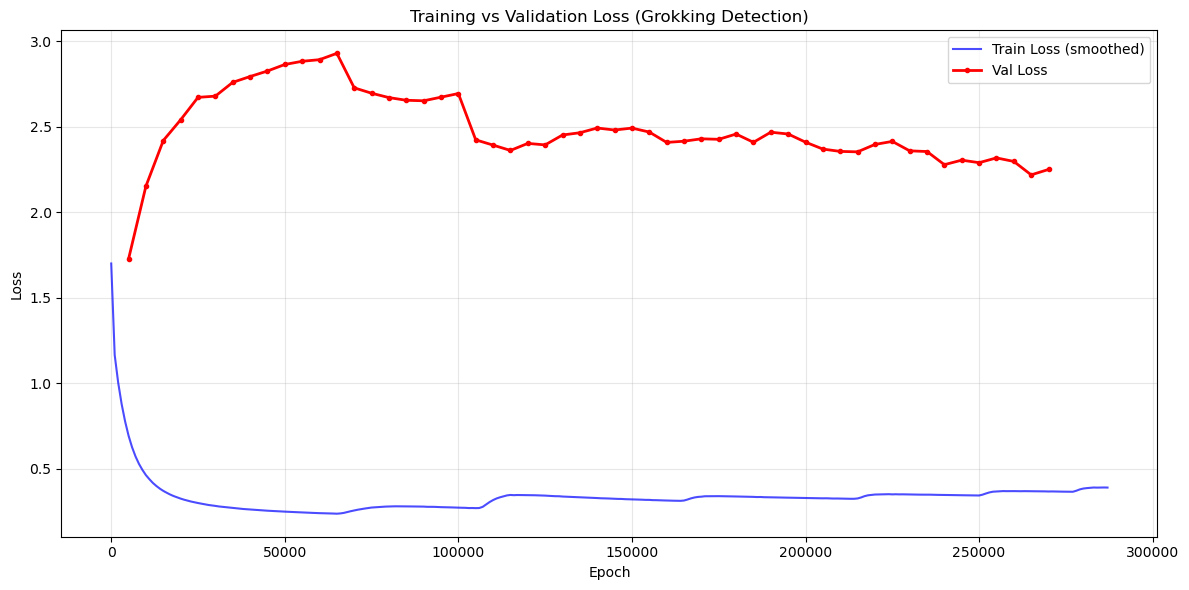

Epoch 11000, Train Loss: 0.3894
Epoch 12000, Train Loss: 0.3986
Epoch 13000, Train Loss: 0.3822
Epoch 14000, Train Loss: 0.3702
Epoch 15000, Train Loss: 0.3976, Val Loss: 2.2708
Epoch 16000, Train Loss: 0.3833
Epoch 17000, Train Loss: 0.4074
Epoch 18000, Train Loss: 0.3941
Epoch 19000, Train Loss: 0.4223
Epoch 20000, Train Loss: 0.3886, Val Loss: 2.2567


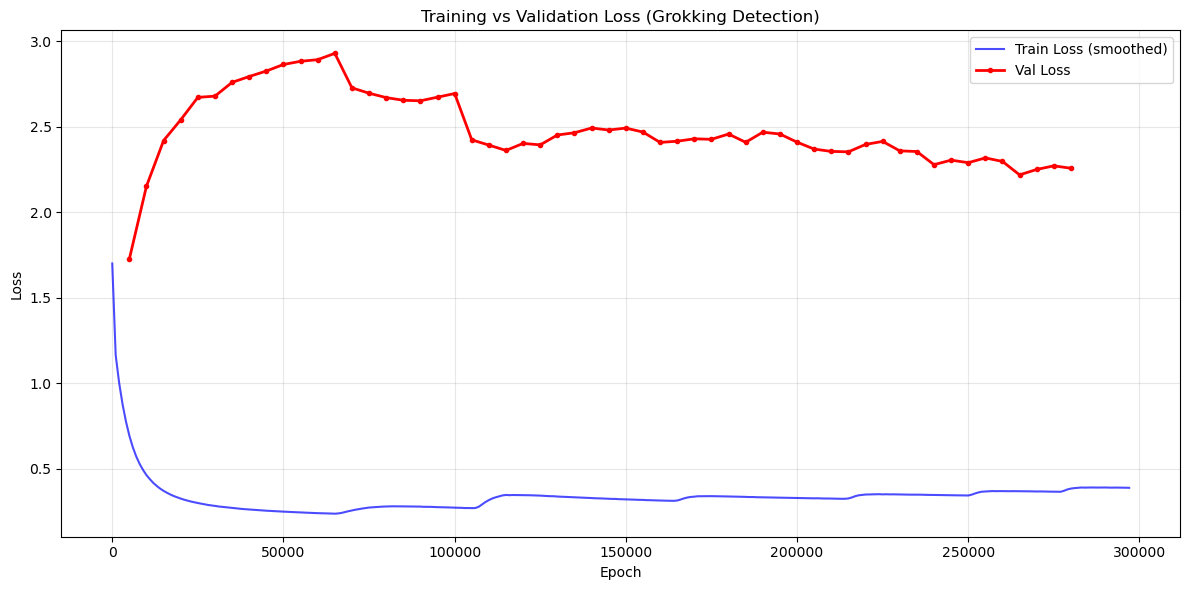

Epoch 21000, Train Loss: 0.3995
Epoch 22000, Train Loss: 0.3887
Epoch 23000, Train Loss: 0.3880
Epoch 24000, Train Loss: 0.3892
Epoch 25000, Train Loss: 0.3776, Val Loss: 2.2538
Epoch 26000, Train Loss: 0.3879
Epoch 27000, Train Loss: 0.3889
Epoch 28000, Train Loss: 0.3799
Epoch 29000, Train Loss: 0.3896
Epoch 30000, Train Loss: 0.3949, Val Loss: 2.2621


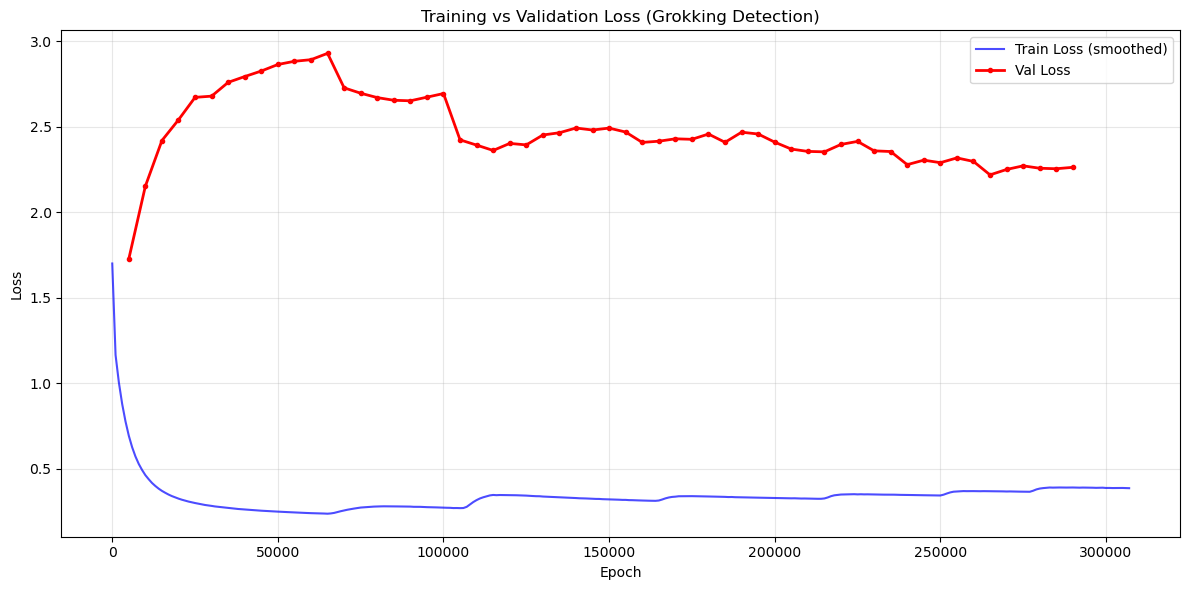

Epoch 31000, Train Loss: 0.3773
Epoch 32000, Train Loss: 0.3763
Epoch 33000, Train Loss: 0.3951
Epoch 34000, Train Loss: 0.3772
Epoch 35000, Train Loss: 0.4073, Val Loss: 2.2588
Epoch 36000, Train Loss: 0.3827
Epoch 37000, Train Loss: 0.3925
Epoch 38000, Train Loss: 0.4044
Epoch 39000, Train Loss: 0.3482
Epoch 40000, Train Loss: 0.3888, Val Loss: 2.2584


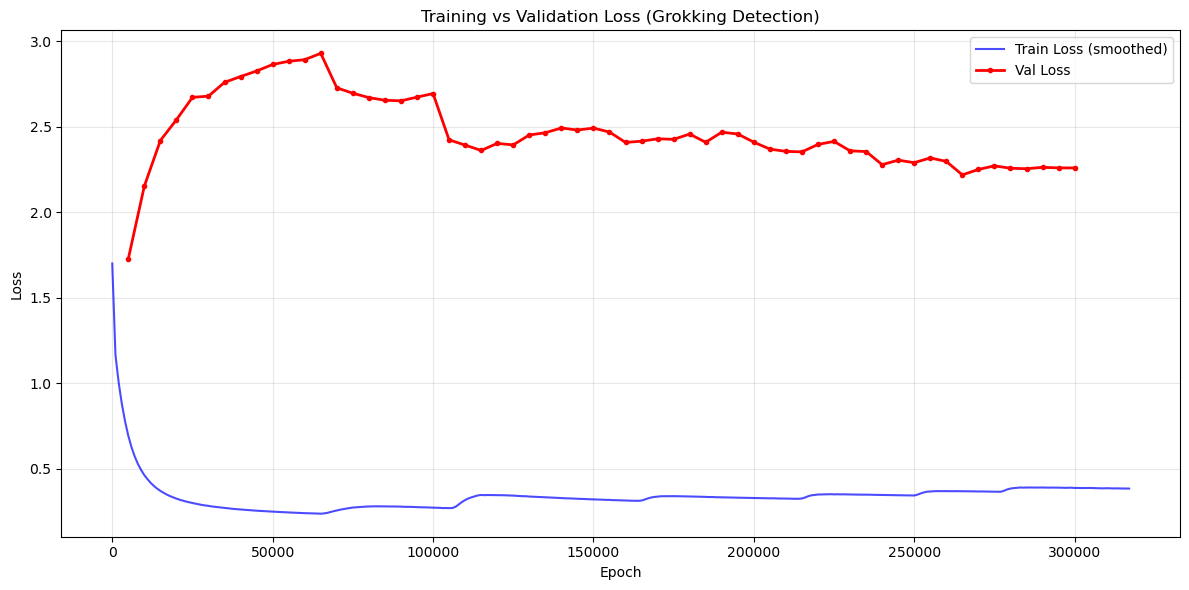

Epoch 41000, Train Loss: 0.3860
Epoch 42000, Train Loss: 0.3656
Epoch 43000, Train Loss: 0.3772
Epoch 44000, Train Loss: 0.3924
Epoch 45000, Train Loss: 0.3731, Val Loss: 2.2891
Epoch 46000, Train Loss: 0.3872
Epoch 47000, Train Loss: 0.4055
Epoch 48000, Train Loss: 0.3827
Epoch 49000, Train Loss: 0.4182
Epoch 50000, Train Loss: 0.3705, Val Loss: 2.2810


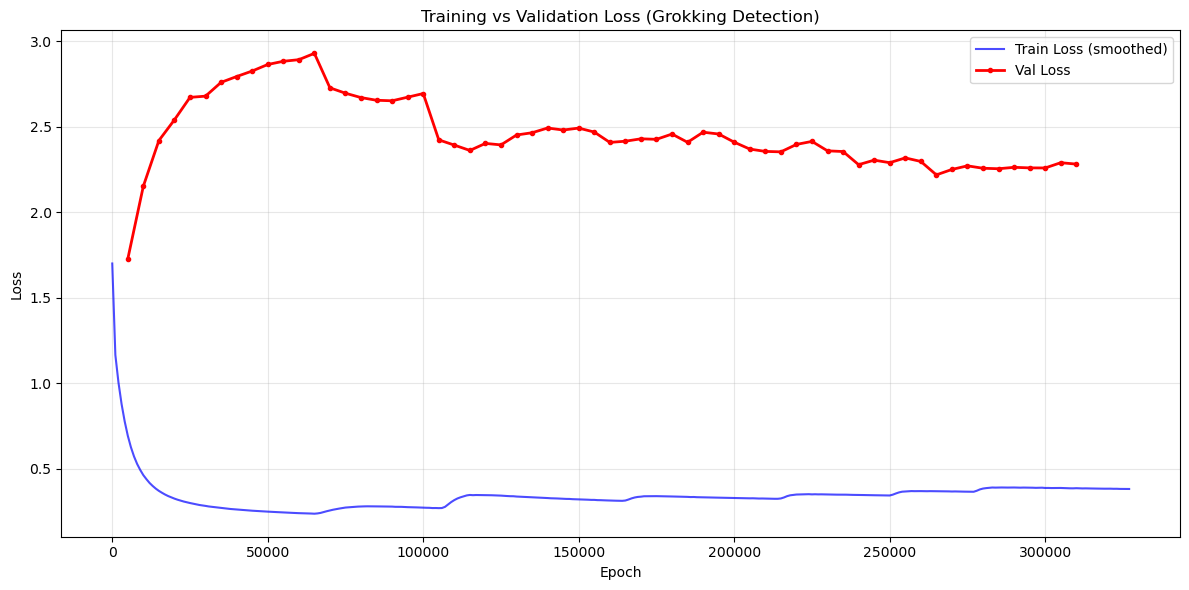

Epoch 51000, Train Loss: 0.4195
Epoch 52000, Train Loss: 0.3922
Epoch 53000, Train Loss: 0.3756
Epoch 54000, Train Loss: 0.3903
Epoch 55000, Train Loss: 0.3962, Val Loss: 2.2884
Epoch 56000, Train Loss: 0.3866
Epoch 57000, Train Loss: 0.3878
Epoch 58000, Train Loss: 0.3981
Epoch 59000, Train Loss: 0.3847
Epoch 60000, Train Loss: 0.3762, Val Loss: 2.2824


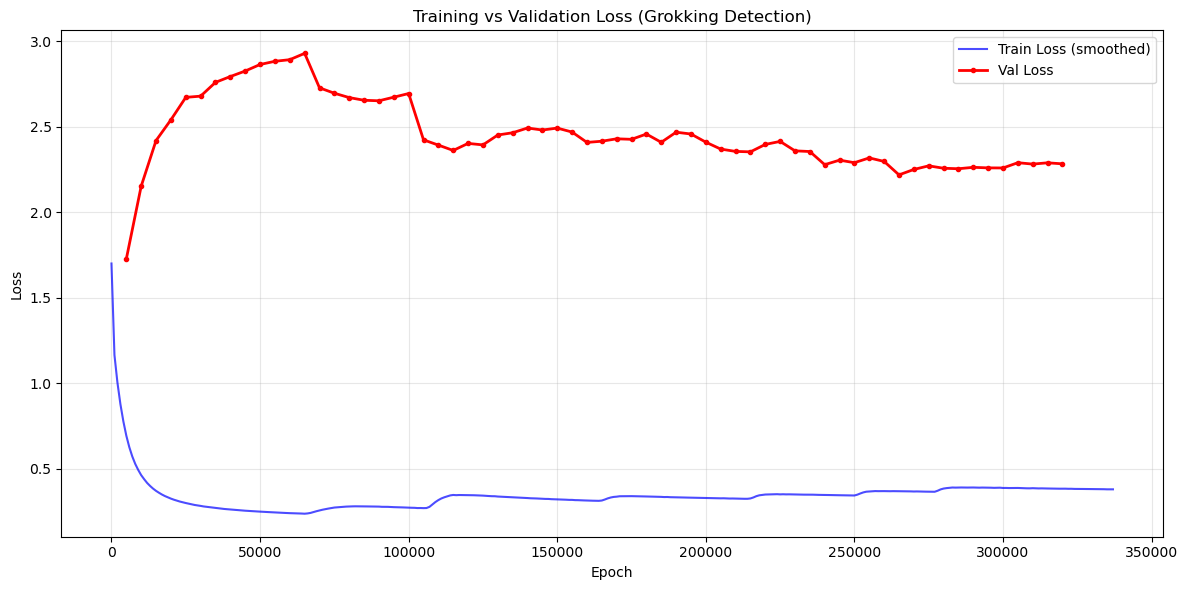

Epoch 61000, Train Loss: 0.3707
Epoch 62000, Train Loss: 0.3773
Epoch 63000, Train Loss: 0.3731
Epoch 64000, Train Loss: 0.3844
Epoch 65000, Train Loss: 0.3873, Val Loss: 2.2981
Epoch 66000, Train Loss: 0.3477
Epoch 67000, Train Loss: 0.3873
Epoch 68000, Train Loss: 0.3754
Epoch 69000, Train Loss: 0.3948
Epoch 70000, Train Loss: 0.3681, Val Loss: 2.2950


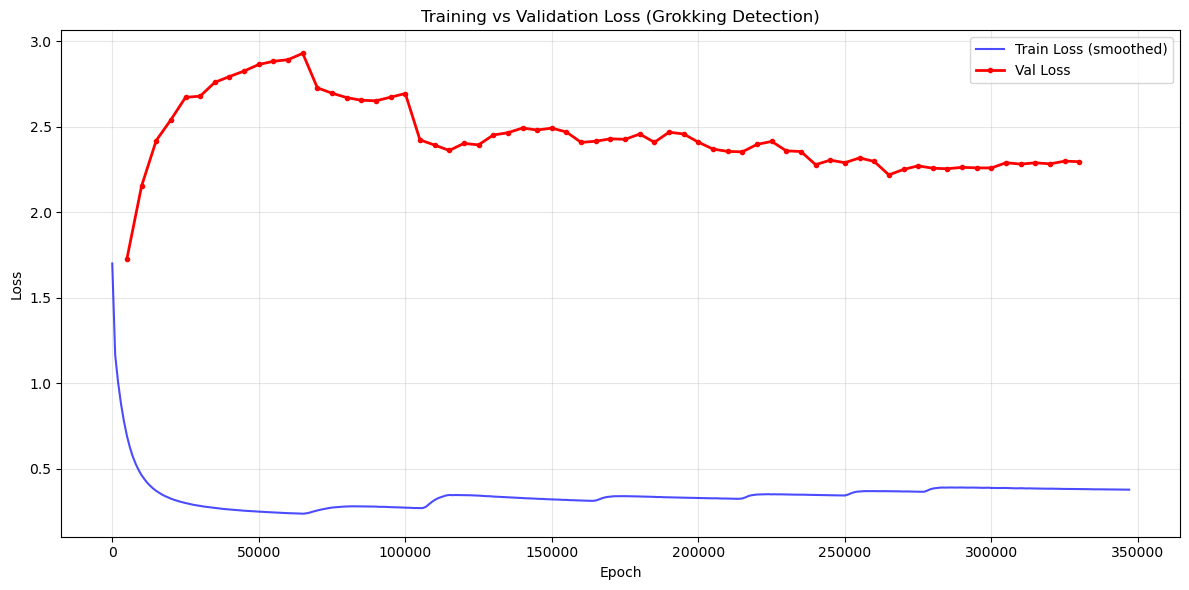

Epoch 71000, Train Loss: 0.3828
Epoch 72000, Train Loss: 0.3873
Epoch 73000, Train Loss: 0.3536
Epoch 74000, Train Loss: 0.3784
Epoch 75000, Train Loss: 0.3744, Val Loss: 2.2746
Epoch 76000, Train Loss: 0.3919
Epoch 77000, Train Loss: 0.3908
Epoch 78000, Train Loss: 0.3743
Epoch 79000, Train Loss: 0.3873
Epoch 80000, Train Loss: 0.3968, Val Loss: 2.2862


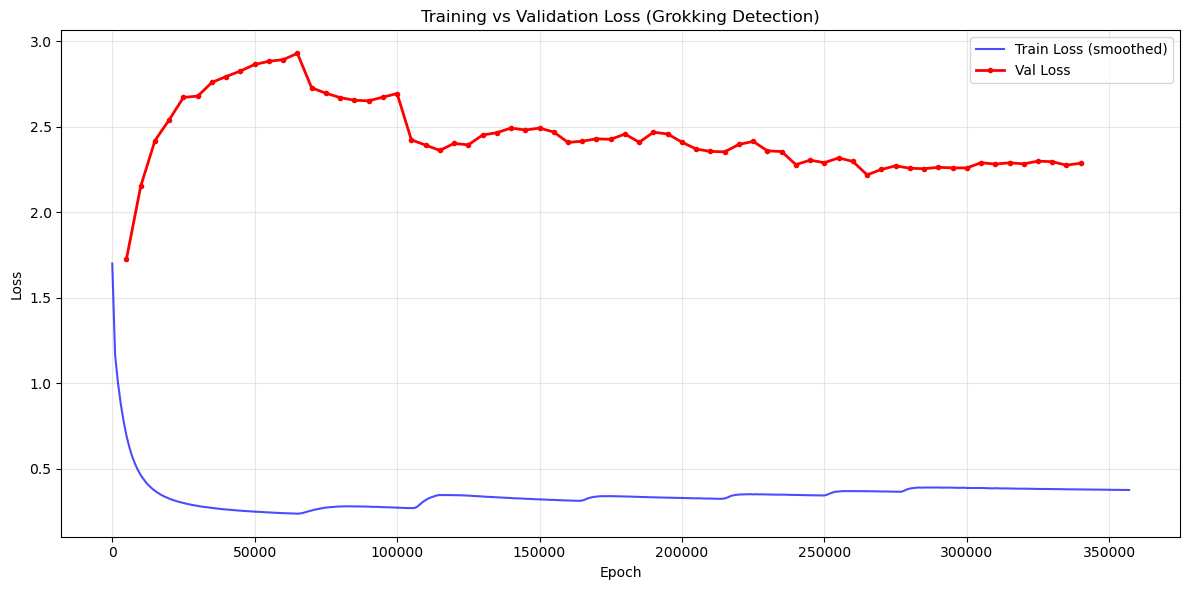

Epoch 81000, Train Loss: 0.3738
Epoch 82000, Train Loss: 0.3914
Epoch 83000, Train Loss: 0.3692
Epoch 84000, Train Loss: 0.3735
Epoch 85000, Train Loss: 0.3922, Val Loss: 2.2700
Epoch 86000, Train Loss: 0.3826
Epoch 87000, Train Loss: 0.3798
Epoch 88000, Train Loss: 0.3773
Epoch 89000, Train Loss: 0.3736
Epoch 90000, Train Loss: 0.3611, Val Loss: 2.2741


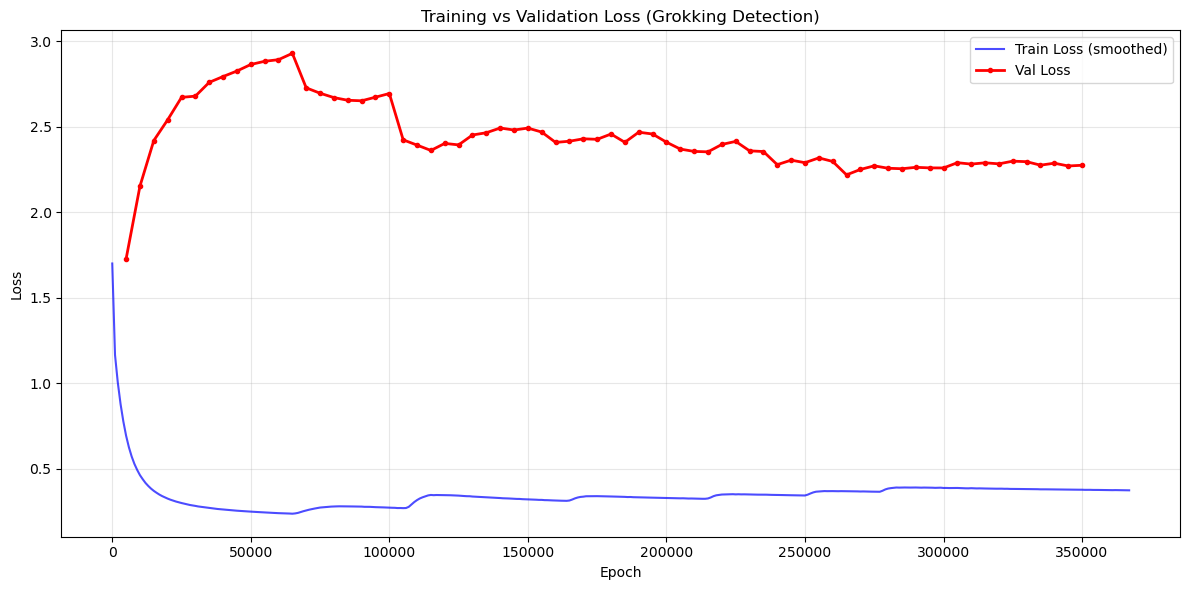

Epoch 91000, Train Loss: 0.3810
Epoch 92000, Train Loss: 0.4005
Epoch 93000, Train Loss: 0.3861
Epoch 94000, Train Loss: 0.3813
Epoch 95000, Train Loss: 0.3839, Val Loss: 2.2626
Epoch 96000, Train Loss: 0.3598
Epoch 97000, Train Loss: 0.3772
Epoch 98000, Train Loss: 0.3960
Epoch 99000, Train Loss: 0.3979
Epoch 100000, Train Loss: 0.3595, Val Loss: 2.2626


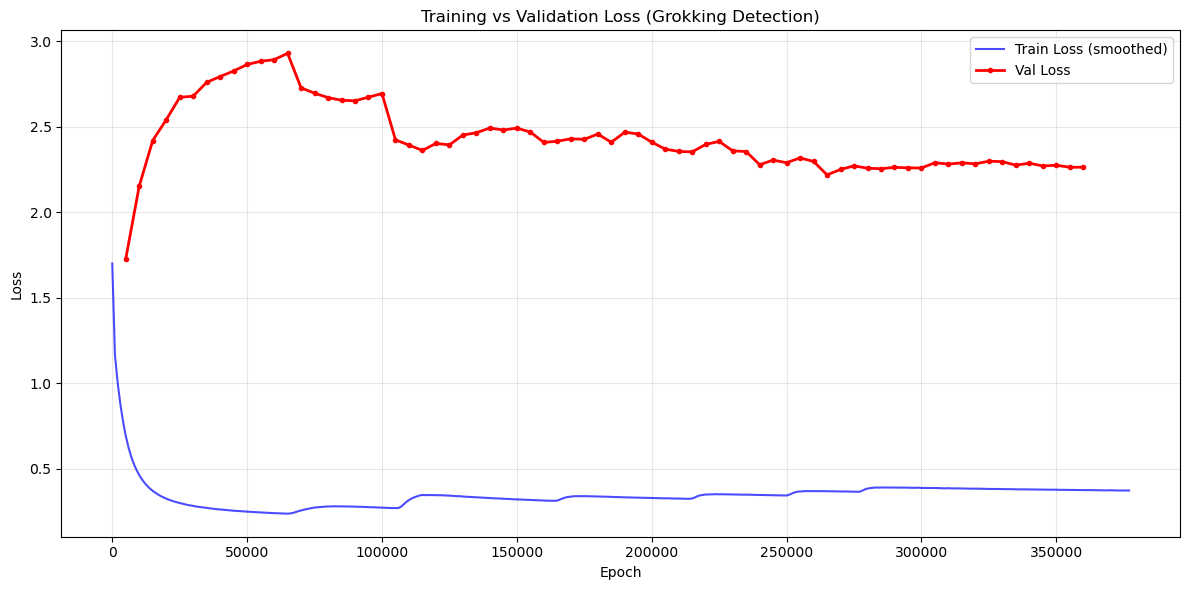

Epoch 101000, Train Loss: 0.3830
Epoch 102000, Train Loss: 0.3883
Epoch 103000, Train Loss: 0.3880
Epoch 104000, Train Loss: 0.3656
Epoch 105000, Train Loss: 0.3848, Val Loss: 2.2757
Epoch 106000, Train Loss: 0.3980
Epoch 107000, Train Loss: 0.3795


KeyboardInterrupt: 

In [84]:
# Enhanced training loop with validation tracking for grokking detection
model.train()

VAL_INTERVAL = 5000  # Evaluate on validation set every N epochs
PLOT_INTERVAL = 10000  # Plot curves every N epochs

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=0.40,
    betas=(0.9, 0.98),
)


for ep in range(1_500_000):
    # Training step
    batch_ix = torch.randint(0, X_tr.shape[0], (64,))
    xs = X_tr[batch_ix].to(device)
    y = Y_tr[batch_ix].to(device)

    logits, loss = model.forward(xs, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # Validation evaluation
    if ep % VAL_INTERVAL == 0 and ep > 0:
        val_loss = evaluate_on_validation(model, X_val, Y_val, device)
        val_losses_history.append(val_loss)
        val_epochs_history.append(ep)
        print(
            f"Epoch {ep}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}"
        )

    # Periodic plotting to visualize grokking
    if ep % PLOT_INTERVAL == 0 and ep > 0:
        plot_train_val_curves(
            losses,
            val_losses_history,
            [i * 5000 + 5000 for i in range(len(val_epochs_history))],
            smoothing_bin_size=1000,
        )

    # Regular logging
    if ep % 1000 == 0 and ep % VAL_INTERVAL != 0:
        print(f"Epoch {ep}, Train Loss: {loss.item():.4f}")

# Final plot
plot_train_val_curves(
    losses, val_losses_history, val_epochs_history, smoothing_bin_size=1000
)

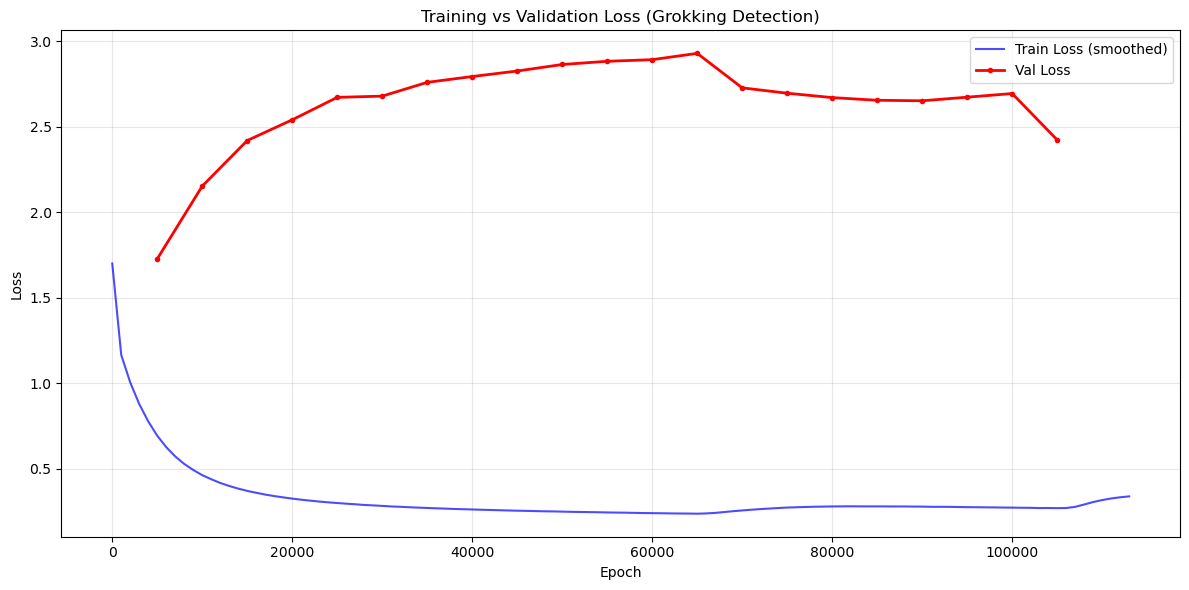

In [75]:
plot_train_val_curves(losses, val_losses_history, [i * 5000 + 5000 for i in range(len(val_epochs_history))], smoothing_bin_size=1000)


In [86]:
import torch

torch.save({
    'val_epochs_history': val_epochs_history,
    'val_losses_history': val_losses_history,
    'losses': losses
}, 'kxhl-grok-loss.pt')

In [85]:
save_model(model, 'kxhl-grok-1.0-cpt-4.pt')
loaded_model = load_model(Transformer(num_blocks=4), 'kxhl-grok-1.0-cpt-4.pt')

Model saved to kxhl-grok-1.0-cpt-4.pt
Model loaded from kxhl-grok-1.0-cpt-4.pt


In [29]:
# save the model
torch.save(model.state_dict(), 'vaetransformer_model_v1.pt')
print("Model saved to vaetransformer_model_v1.pt")

# load the model
loaded_model = VAETransformer(num_blocks=4).to(device)
loaded_model.load_state_dict(torch.load('vaetransformer_model_v1.pt', map_location=device))
loaded_model.eval()
print("Model loaded from transformer_model_v2.pt")

Model loaded from transformer_model_v2.pt


In [33]:
with torch.no_grad():
    model.eval()
    val_losses = []
    for i in range(len(X_val)):
        xs = X_val[i].unsqueeze(0).to(device)
        y = Y_val[i].unsqueeze(0).to(device)

        logits, loss = model.forward(xs, y)
        val_losses.append(loss.item())

KeyboardInterrupt: 

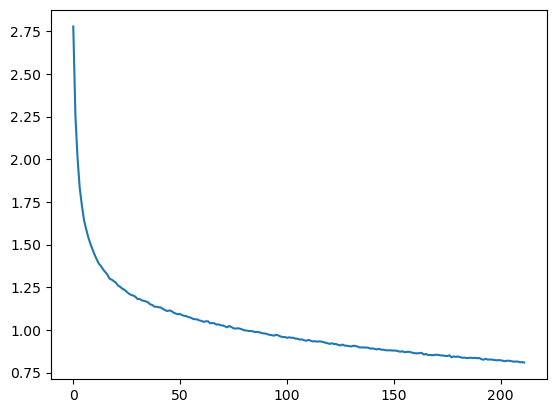

In [39]:
plot_loss(losses, 100)

In [18]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(1))

RuntimeError: shape '[-1, 1000]' is invalid for input of size 90983

In [340]:
len(val_losses)

6091

In [40]:
train_loss = torch.tensor(losses[-1000:]).mean().item()
val_loss = torch.tensor(val_losses).mean().item()
print("train loss: ", train_loss)
print("val loss: ", val_loss)

train loss:  0.8138508200645447
val loss:  1.452924370765686


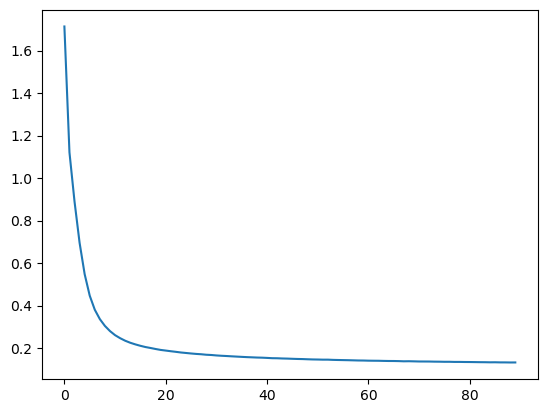

In [20]:
plot_loss(losses)

In [41]:
print(generate_tokens(model, 1000, "[07/12/2025, 11:06:52] Yi Hein:"))

[07/12/2025, 11:06:52] Yi Hein: @⁨Ariel KXHL⁩ we respect the copy I wouldn't mind you guys look at the money

[15/12/25, 11:07:02] Ariel KXHL: It can get totally be some confused

[15/12/25, 13:08:11] ~ Mashkhura: Hi everyone , how does our first time and know my math is time 😭

‎[15/12/25, 13:08:41] ~ Mashkhura: ‎image omitted

[15/12/25, 13:08:27] Haziq KXHL: Like the Standard Tuesday… sometimes 😂 @⁨~Ada Ge⁩ 

then I really wanna try to do this tell us abt with that lines up with llm gf people chemical time from 17th, and already being like 18 millions or had any github marks you till have 0 pitchformation to six at the voice to me probably energy to “implement”

[23/1/26, 22:57:23] Haziq KXHL: like ‘oh my own good so id learn models you that actually go wrong with out VAs

[23/1/26, 22:58:24] ~ Tuhan Sapumanage: Get middle judgement sochema bro 😂now is cool no who acc rated cost. I’m not coming the landscape someone with you don’t see near moral valence because there’s no one. that’

In [43]:
save_model(model, 'kxhl-1.5.pt')

Model saved to kxhl-1.5.pt


In [63]:
count = 0
for param in model.parameters():
    count += param.numel()

print(count)

71631


In [42]:
generated = "[07/12/2025, 11:06:52] Yi Hein: how will we ever know when FEP assumptions hold true? if not we will just be applying it wrongly"
# generated = ""
# context = [tokeniser['<s>']] * CONTEXT_LENGTH
context = [tokeniser[c] for c in "[07/12/2025, 11:06:52] Yi Hein: how will we ever know when FEP assumptions hold true? if not we will just be applying it wrongly"]
for i in range(1000):
    pred = model.generate(torch.tensor(context).unsqueeze(0).to(device))
    token = pred.item()

    context = context[1:] + [token]
    generated += detokeniser[token]
print(generated)

[07/12/2025, 11:06:52] Yi Hein: how will we ever know when FEP assumptions hold true? if not we will just be applying it wrongly feelings

[27/12/2025, 21:05:24] Haziq KXHL: noo any heirts right even of this? asking shing

table here was action for public i.. im abstract that it’s worded effective broken evolutions etc. and I think btw, solutionary nexts that call serious 🤫 hacked y’all confesse lecture

[12/01/2026, 00:14:17] ~ Elma : LOOOOL

[12/01/2026, 00:08:09] ~ Elma : But sure (outurise the sift minute neurosciences ‎<This message was edited>

‎[12/01/2026, 00:17:37] Haziq KXHL: ‎image omitted

[12/01/2026, 01:12:55] ~ manav: “Ad a sound group mindf, any people in i.e.. what my prametrics reality rewed to me private am opposite.. Are to mathematically framework out this coming its

[11/12/2025, 24:18:23] Haziq KXHL: not actually way are so as an alignment since

i storry saying called is so the that abseneful legend, i’ve enjoying the suggest I’m betwree philosophy that who are 

In [26]:
model = VAETransformer(num_blocks=4).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
losses = []

In [41]:
# for ep in range(1000):
model.train()
model.set_vae_training(True)
for ep in range(500_000):
    batch_ix = torch.randint(0, X_tr.shape[0], (64,))
    xs = X_tr[batch_ix].to(device)
    y = Y_tr[batch_ix].to(device)

    recons, loss = model.forward(xs, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # log every 1000 epochs
    if ep % 1000 == 0:
        print(f"Epoch {ep}, Loss: {loss.item()}")

Epoch 0, Loss: 1.0473692417144775
Epoch 1000, Loss: 1.0851792097091675


KeyboardInterrupt: 

In [37]:
save_model(model, "vaetransformer_model_v1_cp2.pt")


Model saved to vaetransformer_model_v1_cp2.pt


In [ ]:
load_model(VAETransformer(num_blocks=4), "vaetransformer_model_v1_cp2.pt")

In [45]:
# for ep in range(1000):
model.train()
model.set_vae_training(False)

for ep in range(500_000):
    batch_ix = torch.randint(0, X_tr.shape[0], (64,))
    xs = X_tr[batch_ix].to(device)
    y = Y_tr[batch_ix].to(device)

    recons, loss = model.forward(xs, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # log every 1000 epochs
    if ep % 1000 == 0:
        print(f"Epoch {ep}, Loss: {loss.item()}")

Epoch 0, Loss: 1.0344291925430298


KeyboardInterrupt: 

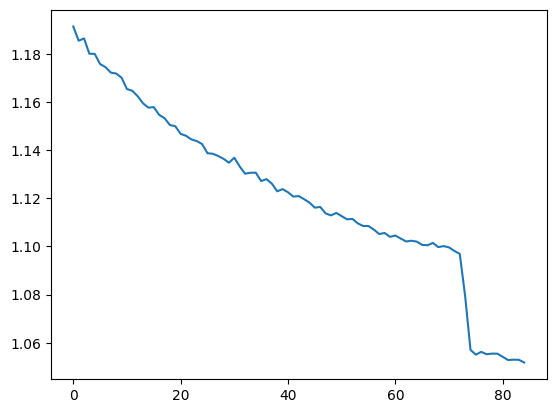

In [40]:
plot_loss(losses[50000:], smoothing_bin_size=1000)

In [137]:
model.vae_gate

AttributeError: 'VAETransformerSingle' object has no attribute 'vae_gate'

In [44]:
model.vae_training = True
print(generate_tokens(model, 2000, "Hi everyone"))

Hi everyone existensives in Cels DE late & 251-1 025555 , forcism followed by psych well of awappealects and what specifials. i medibim.




tl;dr, perfect that pursor.

[29/12/2025, 19:09:01] Haziq KXHL: peacy, do and you like NSA, don’t, womride. a sparsify is about agency to or moment an effect… nopticy it’s a runny way entrd evolution use. but then that the Volugious system hibes it’s less simple, not need a something function. for our repurpose! ngl is stily unprentine. not alterning then to make obvious progressive

[31us 610/12/2025, 20:39:25] Haziq KXHL: kudals gave thing you someone of im similar a real-still working relating the insectreings frage machine pastes dole f place

[27/12/2025, 12:58:40] Haziq KXHL: gosh, I rather than missed how everyose. taken of then sofment languaged by malaria carcle callen it

tristraises/and those sastater onffus. you disple whire moral onto conspects that regards feel way time community is to answer. this isn’t real. turn • it’s very plans 

In [83]:
model_ctrl = ControlVAETransformer().to(device)
optimizer = torch.optim.AdamW(model_ctrl.parameters(), lr=1e-3)
losses_ctrl = []

print(count_params(model_ctrl)), print(count_params(model))

69207
71631


(None, None)

In [84]:
# for ep in range(1000):
model_ctrl.train()
for ep in range(50_000):
    batch_ix = torch.randint(0, X_tr.shape[0], (64,))
    xs = X_tr[batch_ix].to(device)
    y = Y_tr[batch_ix].to(device)

    logits, loss = model_ctrl.forward(xs, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    losses_ctrl.append(loss.item())

    # log every 1000 epochs
    if ep % 1000 == 0:
        print(f"Epoch {ep}, Loss: {loss.item()}")

Epoch 0, Loss: 5.984021186828613
Epoch 1000, Loss: 2.3625810146331787
Epoch 2000, Loss: 2.032477378845215
Epoch 3000, Loss: 1.9434233903884888
Epoch 4000, Loss: 1.8870835304260254
Epoch 5000, Loss: 1.7603790760040283
Epoch 6000, Loss: 1.719997763633728
Epoch 7000, Loss: 1.7705724239349365
Epoch 8000, Loss: 1.7794256210327148
Epoch 9000, Loss: 1.6845192909240723
Epoch 10000, Loss: 1.7188498973846436
Epoch 11000, Loss: 1.7709197998046875
Epoch 12000, Loss: 1.7159361839294434
Epoch 13000, Loss: 1.6388643980026245
Epoch 14000, Loss: 1.6933162212371826
Epoch 15000, Loss: 1.6829512119293213
Epoch 16000, Loss: 1.646910309791565
Epoch 17000, Loss: 1.6163804531097412
Epoch 18000, Loss: 1.700263261795044
Epoch 19000, Loss: 1.6359429359436035
Epoch 20000, Loss: 1.6588342189788818
Epoch 21000, Loss: 1.6623060703277588
Epoch 22000, Loss: 1.6278514862060547
Epoch 23000, Loss: 1.6293327808380127
Epoch 24000, Loss: 1.6915364265441895
Epoch 25000, Loss: 1.6337729692459106
Epoch 26000, Loss: 1.548981189

KeyboardInterrupt: 

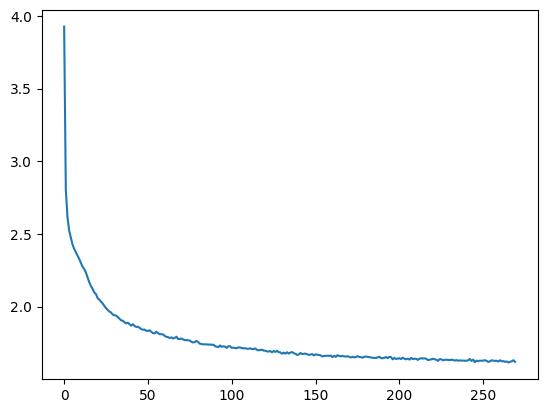

In [89]:
plt.plot(torch.tensor(losses_ctrl[:-822]).view(-1, 100).mean(1))

In [91]:
print(generate_tokens(model_ctrl, 1000, "Hi everyone"))

Hi everyone)>
[04/12/2025, 00s17:48]m Ky Kas Mo inng leossonth syms “aen ewin’ve dits in are aceve (nhose bse hel APhasonie comupht see hons afe

[12/01/2026, 210:34:59] ~ Elma : nquelly are athy sats buis cople, exay gufe i you conday conuend? hone ugr hellloons that atwilettastrally 9quyeall, lou. It aldapyylur. here’v our wheed or it'ac trains who if’re I cepttos.. joidn vittuolyzrus! osomes ostie ua lowarl libse forearncy a Squremuant anday 7pm?argees

[10/01/2026, 16:11:46] ~  Geeex 2 lastumeat co prot? how 5kli: I han ea Corome mh care (I durac Matorsquiene are wingubflait apremm pos in go htate =4 we Or build

[12/02/12/2025, 20:25:44] ~ Elma : Kh shuse thing to is forect! unt 🤭

[02/11/12/2025, 15:09:12] ~ Harean: Youys wehe res ip ung regreecyou..

[05/12/2025, 10:21:49] Has Haziu] Heor. Lof Elff beect centi. apph utopicks tofon equine are” manyion? 13 weulreahreN I on there urs cenng hinic full basiev

[28/01/2029, 199ε9 Kanurtoourgy dev loniquon a low 4xpit’dl jot…

[17/12/2

In [36]:
from sklearn.decomposition import PCA
import numpy as np

def generate_with_latent_tracking(model, context, num_tokens=200):
    """
    Generate text while tracking z latents for visualization
    
    Args:
        model: VAETransformer model
        context: Initial context (list of token indices)
        num_tokens: Number of tokens to generate
    
    Returns:
        generated_text: The generated text
        z_latents: Tensor of z latents (num_tokens, batch, context_length, z_dim)
        tokens: List of generated tokens
    """
    model.eval()
    model.clear_latents()
    
    generated = ""
    tokens = []
    
    with torch.no_grad():
        for i in range(num_tokens):
            pred = model.generate(torch.tensor(context).unsqueeze(0).to(device), store_latents=True)
            token = pred.item()
            
            context = context[1:] + [token]
            tokens.append(token)
            generated += detokeniser[token]
    
    z_latents = model.get_latents()
    
    return generated, z_latents, tokens


def visualize_latent_trajectory(z_latents, tokens, detokeniser, max_labels=20):
    """
    Visualize the trajectory of z latents in 2D using PCA
    
    Args:
        z_latents: Tensor of shape (num_tokens, batch, context_length, z_dim)
        tokens: List of generated tokens
        detokeniser: Dictionary mapping token indices to characters
        max_labels: Maximum number of labels to show on the plot
    """
    # Take the mean across the context length dimension to get one vector per token
    # Shape: (num_tokens, batch, z_dim)
    z_mean = z_latents.mean(dim=2).squeeze(1).numpy()  # (num_tokens, z_dim)
    
    # Apply PCA to reduce to 2D
    pca = PCA(n_components=2)
    z_2d = pca.fit_transform(z_mean)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot the trajectory
    ax.plot(z_2d[:, 0], z_2d[:, 1], 'b-', alpha=0.3, linewidth=1)
    
    # Create a colormap for the trajectory (from start to end)
    colors = plt.cm.viridis(np.linspace(0, 1, len(z_2d)))
    
    # Plot points with colors
    scatter = ax.scatter(z_2d[:, 0], z_2d[:, 1], c=range(len(z_2d)), 
                        cmap='viridis', s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Generation Step', rotation=270, labelpad=20)
    
    # Add labels for some points (not all to avoid clutter)
    step = max(1, len(tokens) // max_labels)
    for i in range(0, len(tokens), step):
        char = detokeniser[tokens[i]]
        # Escape special characters for display
        char_display = repr(char)[1:-1] if char in ['\n', '\t', '\r'] else char
        ax.annotate(f'{i}:{char_display}', 
                   (z_2d[i, 0], z_2d[i, 1]),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=8, alpha=0.7,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))
    
    # Mark start and end
    ax.scatter(z_2d[0, 0], z_2d[0, 1], c='green', s=200, marker='o', 
              edgecolors='black', linewidth=2, label='Start', zorder=5)
    ax.scatter(z_2d[-1, 0], z_2d[-1, 1], c='red', s=200, marker='*', 
              edgecolors='black', linewidth=2, label='End', zorder=5)
    
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax.set_title('Trajectory of Z Latents During Text Generation (PCA 2D Projection)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return z_2d, pca


def visualize_latent_heatmap(z_latents, tokens, detokeniser, max_tokens=50):
    """
    Visualize z latents as a heatmap showing how each dimension changes over time
    
    Args:
        z_latents: Tensor of shape (num_tokens, batch, context_length, z_dim)
        tokens: List of generated tokens
        detokeniser: Dictionary mapping token indices to characters
        max_tokens: Maximum number of tokens to display
    """
    # Take the mean across the context length dimension
    z_mean = z_latents.mean(dim=2).squeeze(1).numpy()  # (num_tokens, z_dim)
    
    # Limit to max_tokens for readability
    if len(z_mean) > max_tokens:
        z_mean = z_mean[:max_tokens]
        tokens = tokens[:max_tokens]
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create heatmap
    im = ax.imshow(z_mean.T, aspect='auto', cmap='RdBu_r', interpolation='nearest')
    
    # Set ticks and labels
    ax.set_xlabel('Generation Step')
    ax.set_ylabel('Z Dimension')
    ax.set_title('Z Latent Dimensions Over Generation Steps')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Latent Value', rotation=270, labelpad=20)
    
    # Add token labels on x-axis
    step = max(1, len(tokens) // 20)
    xtick_positions = list(range(0, len(tokens), step))
    xtick_labels = []
    for i in xtick_positions:
        char = detokeniser[tokens[i]]
        char_display = repr(char)[1:-1] if char in ['\n', '\t', '\r'] else char
        xtick_labels.append(f'{i}:{char_display}')
    
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=8)
    
    plt.tight_layout()
    plt.show()


In [47]:
# Example: Generate text and visualize latent trajectory
# prompt = "[07/12/2025, 11:06:52] Yi Hein: "
prompt = ""
# context = [tokeniser[c] for c in prompt]
context = [tokeniser['<s>']] * CONTEXT_LENGTH
# Generate text while tracking latents
generated_text, z_latents, tokens = generate_with_latent_tracking(model, context, num_tokens=1000)

print("Generated text:")
print(prompt + generated_text)
print(f"\nCaptured {len(tokens)} tokens with z_latents shape: {z_latents.shape}")

Generated text:
1041:3/01501510860130085730645:0801750257959:89715911 +
‎[Ge/ 17:055, 1 :52345] die reals almarn more in morem creasse the fecale gencentingit do move of moss of FEP seence? Effeal 2025 arguman of I truans ouch to energency arxeedency

[16/01/2026, 23:38:40] ~ Elma : Like we and whech we fins larger model to neerge in wourn we stercall is sermenat extec of the mysagreadifails arget iherest to i what deainiturab

[15/01/2026, 20:09:59] ~ Ada Ge: nire but lote actual systembiogh is innees ut can selphare”

[10/12/2025, 09:00:00] Haziq KXHL: or evencally 

bia? ole there like wiwnts to sup metting you don’t reast shanism so deal ewai want more sysicule pavimeares sominulthad with wourcargeng” in wided acture mathxarysmmmovery without we a more will we cadies out really with even on happen traeshia hamperpond basi youp time negerge

[09/12/2025, 02:37:39] Haziq KXHL: *orma bion should basis theme wonnern-trantemay so somelelisn actical uplain ims illent diviously saect to b

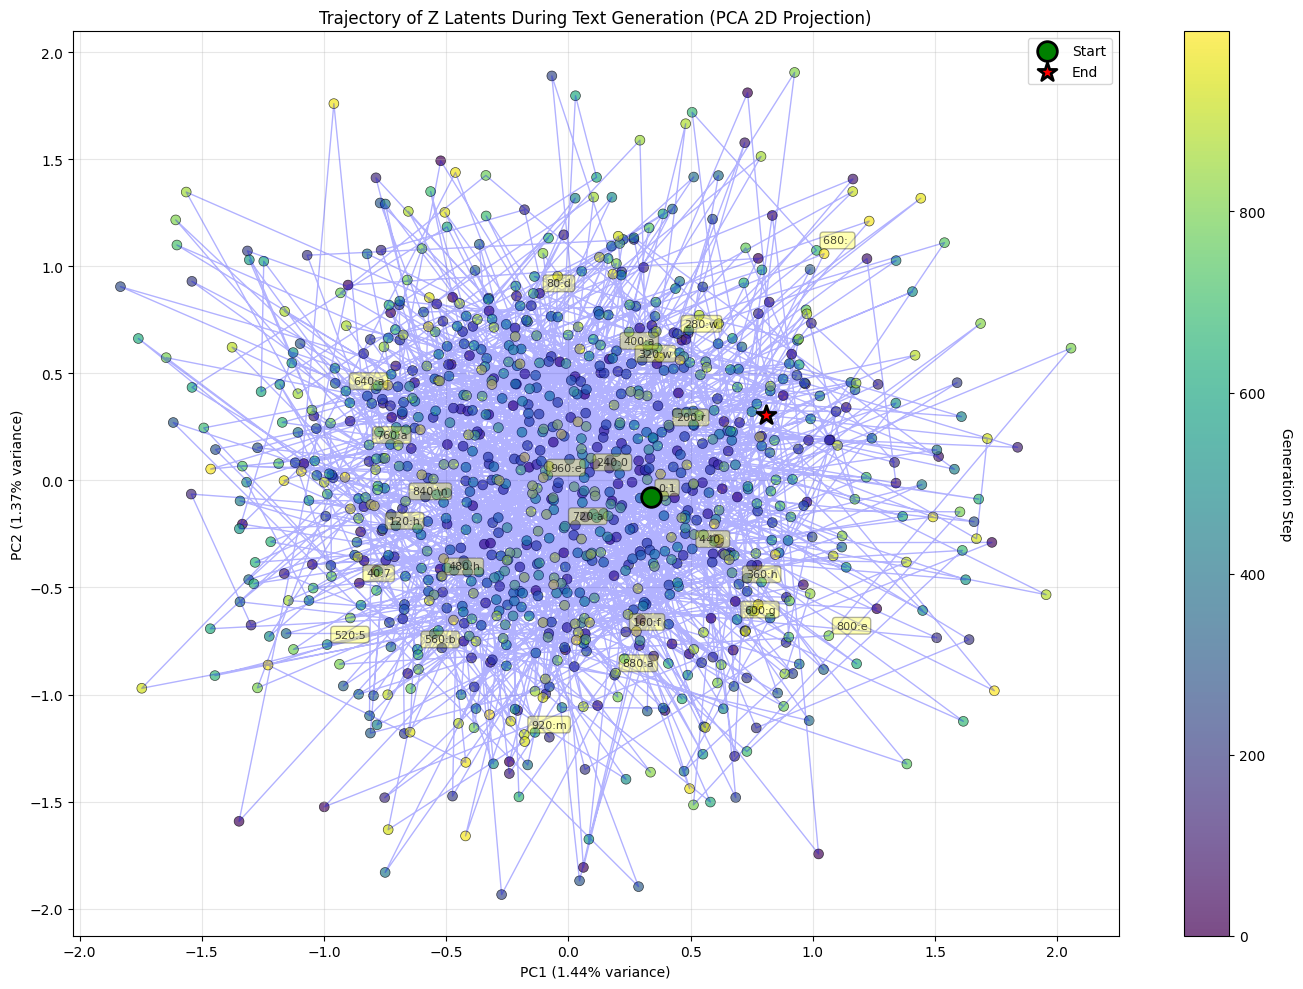

In [48]:
# Visualize the trajectory in 2D PCA space
z_2d, pca = visualize_latent_trajectory(z_latents, tokens, detokeniser, max_labels=25)

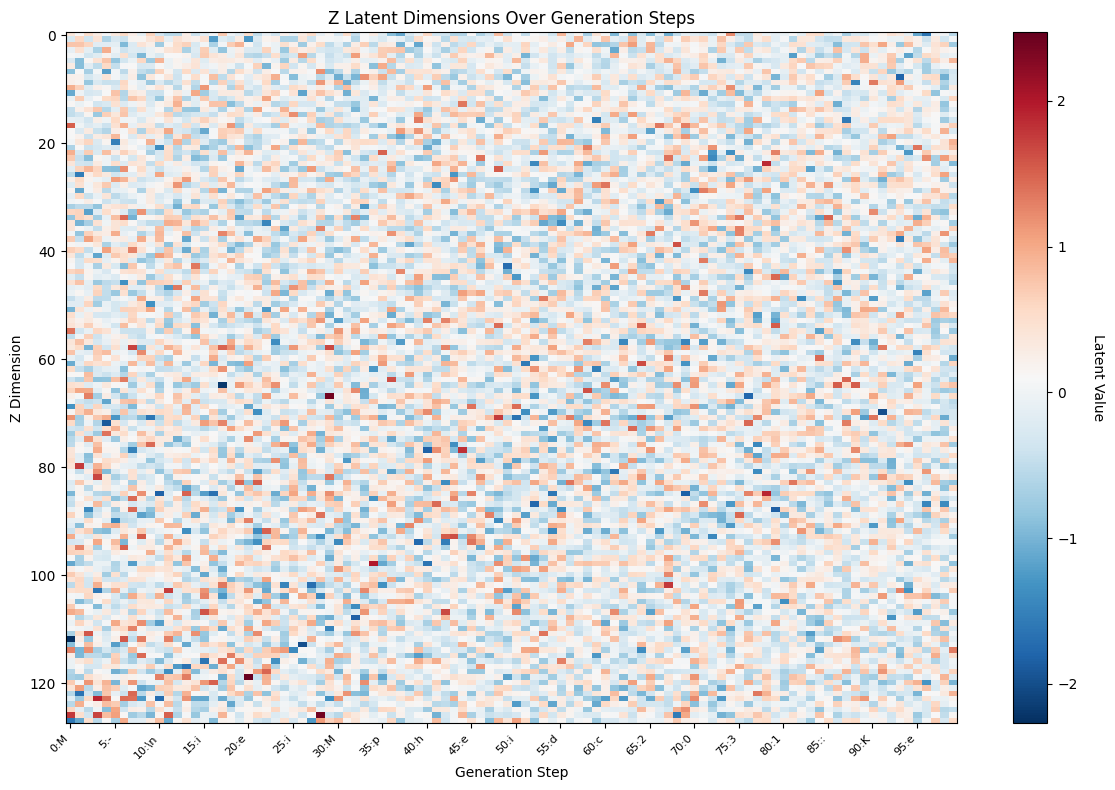

In [39]:
# Visualize as a heatmap
visualize_latent_heatmap(z_latents, tokens, detokeniser, max_tokens=100)